In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install matplotlib
!pip install segyio
!pip install numpy
!pip install tqdm
!pip install pandas
!pip install sklearn
!pip install tensorflow
!pip install scipy

<div class="alert alert-block alert-info">
<b> Загрузка библиотек </b>
</div>

In [1]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import segyio as s
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys

from scipy import interpolate
from scipy.interpolate import NearestNDInterpolator

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.random.set_seed(8)
np.random.seed(8)

<div class="alert alert-block alert-info">
<b> Инфо о данных</b>
</div>

In [4]:
data = Path('data')

seis = data / 'seismic_cube_cropped.sgy'
seis_inter = data / 'seismic_interpretation_layer_0.charisma'
heff_train = data / 'heff_train.txt'
heff_test = data / 'heff_test.txt'
heff_blind_test = data / 'heff_blind_test.txt'

<div class="alert alert-block alert-info">
<b> Геол часть</b>
</div>


ilines starts in from 62, xlines starts from 1, depth starts from 1350.0


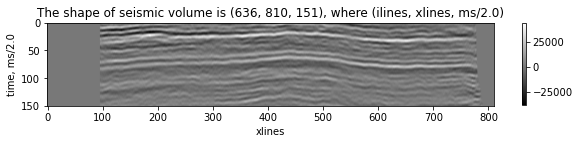

In [5]:
seis_npy = s.tools.cube(seis)

# selected variables for preview
iline = 100
xline = 200


with s.open(seis) as sgy_file_data:
        ILINE_START = int(sgy_file_data.header.segy.ilines[0])
        XLINE_START = int(sgy_file_data.header.segy.xlines[0])
        dt = sgy_file_data.header.segy.samples[1] - sgy_file_data.header.segy.samples[0]
        DEPTH_IN_TIME = int(sgy_file_data.header.segy.samples.min() / dt)

print()
print(f'ilines starts in from {ILINE_START}, xlines starts from {XLINE_START}, depth starts from {DEPTH_IN_TIME*dt}')
        
plt.figure(figsize=(10,10))
vertical_view = plt.imshow(seis_npy[iline, :, :].T, cmap='gray')
plt.title(f'The shape of seismic volume is {seis_npy.shape}, where (ilines, xlines, ms/{dt})')
plt.ylabel(f'time, ms/{dt}')
plt.xlabel('xlines')
plt.colorbar(vertical_view, shrink=0.15)
plt.show()
plt.close()

In [6]:
charisma = pd.read_csv(seis_inter, delim_whitespace=True, names=[
    'd1','d2','iline_number','d3','d4','xline_number','x', 'y','z'
], engine='c')

charisma.drop(['d1', 'd2', 'd3', 'd4'], axis=1, inplace=True)
charisma.head()

,iline_number,xline_number,x,y,z
0,92,97,-1.546237e+06,7.358613e+06,1515.63074
1,92,98,-1.546214e+06,7.358603e+06,1515.89050
2,92,101,-1.546145e+06,7.358576e+06,1520.66931
3,92,102,-1.546122e+06,7.358566e+06,1523.70129
4,92,103,-1.546099e+06,7.358557e+06,1523.82043


In [7]:
charisma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443642 entries, 0 to 443641
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   iline_number  443642 non-null  int64  
 1   xline_number  443642 non-null  int64  
 2   x             443642 non-null  float64
 3   y             443642 non-null  float64
 4   z             443642 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 16.9 MB


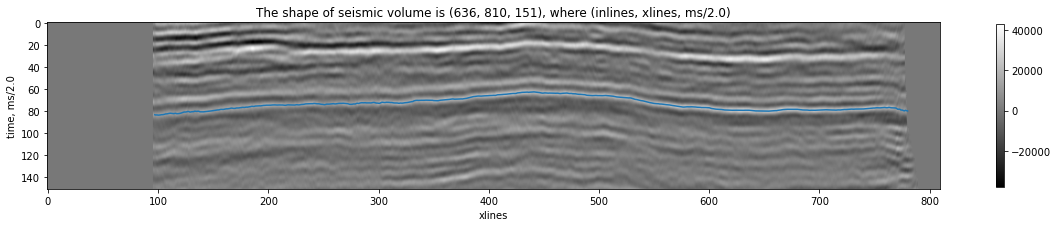

In [8]:
charisma_filtered = charisma[charisma.iline_number == (iline + ILINE_START)]

plt.figure(figsize=(20,20))
vertical_view = plt.imshow(seis_npy[iline, :, :].T, cmap='gray')
plt.plot(charisma_filtered.xline_number, (charisma_filtered.z - DEPTH_IN_TIME*dt) / dt)
plt.title(f'The shape of seismic volume is {seis_npy.shape}, where (inlines, xlines, ms/{dt})')
plt.ylabel(f'time, ms/{dt}')
plt.xlabel('xlines')
plt.colorbar(vertical_view, shrink=0.15)
plt.show()

In [9]:
#тренировочные данные с толщинами
heff_train_df = pd.read_csv(heff_train, sep=' ', names=['x', 'y', 'heff'], engine='c')
heff_train_df.head(5)

,x,y,heff
0,-1.532016e+06,7.363748e+06,3.4
1,-1.539054e+06,7.355771e+06,7.7
2,-1.540626e+06,7.370969e+06,11.9
3,-1.532180e+06,7.364752e+06,5.1
4,-1.538273e+06,7.371313e+06,3.4


In [10]:
#тестовые данные без толщин
heff_test_df = pd.read_csv(heff_test, sep=' ', names=['x', 'y', 'heff'], engine='c')
heff_test_df.head(5)

,x,y,heff
0,-1.527757e+06,7.362941e+06,NaN
1,-1.538875e+06,7.355904e+06,NaN
2,-1.535992e+06,7.360856e+06,NaN
3,-1.538367e+06,7.370929e+06,NaN


In [11]:
#контрольный тест без толщин
heff_blind_test_df = pd.read_csv(heff_blind_test, sep=' ', names=['x', 'y', 'heff'], engine='c')
heff_blind_test_df.head(5)

,x,y,heff
0,-1.538307e+06,7.370058e+06,4.380791
1,-1.536243e+06,7.357921e+06,4.273922
2,-1.532837e+06,7.362010e+06,3.490603
3,-1.541634e+06,7.357715e+06,3.531694


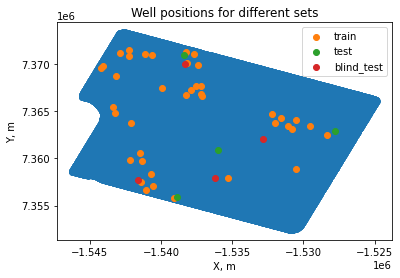

Length of train dataset is 40 wells, length of test dataset is 4 wells, length of blind test dataset is 4 wells


In [12]:
#карта нахождения точек из файлов выше
plt.scatter(charisma.x, charisma.y)
plt.scatter(heff_train_df.x, heff_train_df.y, label='train')
plt.scatter(heff_test_df.x, heff_test_df.y, label='test')
plt.scatter(heff_blind_test_df.x, heff_blind_test_df.y, label='blind_test')
plt.legend()
plt.title('Well positions for different sets')
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.show()

#длины наборов данных
print(f'Length of train dataset is {len(heff_train_df.index)} wells, length of test dataset \
is {len(heff_test_df.index)} wells, length of blind test dataset is {len(heff_blind_test_df.index)} wells')

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

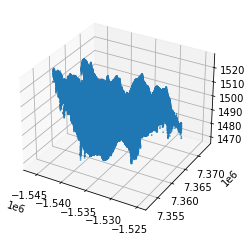

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(charisma.x,charisma.y, charisma.z, s = 0.5, depthshade=True)

<div class="alert alert-block alert-info">
<b> Подготовка данных</b>
</div>

In [15]:
#создание фрейма с интерпретацией, координатами и толщинами из файла интерпретации
whole_df = charisma.copy()
whole_df['wellname'] = 'none'
whole_df.head()

,iline_number,xline_number,x,y,z,wellname
0,92,97,-1.546237e+06,7.358613e+06,1515.63074,none
1,92,98,-1.546214e+06,7.358603e+06,1515.89050,none
2,92,101,-1.546145e+06,7.358576e+06,1520.66931,none
3,92,102,-1.546122e+06,7.358566e+06,1523.70129,none
4,92,103,-1.546099e+06,7.358557e+06,1523.82043,none


In [16]:
#подготовка тренировочного набора (прописываение названия скважины)
heff_train_df['wellname'] = [f'well_train_{i}' for i in range(heff_train_df.shape[0])]
heff_train_df.head()

,x,y,heff,wellname
0,-1.532016e+06,7.363748e+06,3.4,well_train_0
1,-1.539054e+06,7.355771e+06,7.7,well_train_1
2,-1.540626e+06,7.370969e+06,11.9,well_train_2
3,-1.532180e+06,7.364752e+06,5.1,well_train_3
4,-1.538273e+06,7.371313e+06,3.4,well_train_4


In [17]:
#аналогично с тестовыми
heff_test_df['wellname'] = [f'well_test_{i}' for i in range(heff_test_df.shape[0])]

heff_blind_test_df['wellname'] = [f'well_blind_test_{i}' for i in range(heff_blind_test_df.shape[0])]

heff_test_df.head(), heff_blind_test_df.head()

(              x             y  heff     wellname
 0 -1.527757e+06  7.362941e+06   NaN  well_test_0
 1 -1.538875e+06  7.355904e+06   NaN  well_test_1
 2 -1.535992e+06  7.360856e+06   NaN  well_test_2
 3 -1.538367e+06  7.370929e+06   NaN  well_test_3,
               x             y      heff           wellname
 0 -1.538307e+06  7.370058e+06  4.380791  well_blind_test_0
 1 -1.536243e+06  7.357921e+06  4.273922  well_blind_test_1
 2 -1.532837e+06  7.362010e+06  3.490603  well_blind_test_2
 3 -1.541634e+06  7.357715e+06  3.531694  well_blind_test_3)

In [19]:
def transform(heff_df, whole_df):

    well_name = heff_df.wellname
    
    x_w = heff_df.x
    y_w = heff_df.y
#    print(x_w, y_w)
    
    x_g = whole_df.x
    y_g = whole_df.y
#    print(x_g, y_g)

    step = 25
    for n in range(x_w.shape[0]):

        f_x = whole_df[
            (x_g >= (x_w[n] - step)) & 
            (x_g <= (x_w[n] + step)) & 
            (y_g >= (y_w[n] - step)) & 
            (y_g <= (y_w[n] + step))].x
#        print(x_w[n], n, x_g)
        f_y = whole_df[
            (x_g >= (x_w[n] - step)) & 
            (x_g <= (x_w[n] + step)) & 
            (y_g >= (y_w[n] - step)) & 
            (y_g <= (y_w[n] + step))].y
    
        dist = sys.maxsize
   
        for i in range(f_x.shape[0]):
            dist_curr = np.sqrt(np.power(x_w[n] - f_x.iloc[i],2) + np.power(y_w[n] - f_y.iloc[i],2))
            if dist_curr < dist:
                dist = dist_curr
                ind = f_x.index[1] 
                
        whole_df.loc[ind, 'wellname'] = well_name[n]

In [20]:
# for train settransform(heff_train_df, whole_df)
transform(heff_train_df, whole_df)

# for test set
transform(heff_test_df, whole_df)

# for blind test set
transform(heff_blind_test_df, whole_df)

In [21]:
whole_df['Heff'] = np.nan
whole_df['well_x_original'] = np.nan
whole_df['well_y_original'] = np.nan

In [22]:
# for train set
for k in tqdm(heff_train_df.index):
    line = heff_train_df.loc[k]
    
    whole_df.at[whole_df[whole_df['wellname'] == line.wellname].index, 'Heff'] = line.heff
    whole_df.at[whole_df[whole_df['wellname'] == line.wellname].index, 'well_x_original'] = line.x
    whole_df.at[whole_df[whole_df['wellname'] == line.wellname].index, 'well_y_original'] = line.y
    
    
# for test set
for k in tqdm(heff_test_df.index):
    line = heff_test_df.loc[k]
    
    whole_df.at[whole_df[whole_df['wellname'] == line.wellname].index, 'Heff'] = line.heff
    whole_df.at[whole_df[whole_df['wellname'] == line.wellname].index, 'well_x_original'] = line.x
    whole_df.at[whole_df[whole_df['wellname'] == line.wellname].index, 'well_y_original'] = line.y
    
    
# for train set
for k in tqdm(heff_blind_test_df.index):
    line = heff_blind_test_df.loc[k]
    
    whole_df.at[whole_df[whole_df['wellname'] == line.wellname].index, 'Heff'] = line.heff
    whole_df.at[whole_df[whole_df['wellname'] == line.wellname].index, 'well_x_original'] = line.x
    whole_df.at[whole_df[whole_df['wellname'] == line.wellname].index, 'well_y_original'] = line.y

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.37it/s]


In [23]:
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443642 entries, 0 to 443641
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   iline_number     443642 non-null  int64  
 1   xline_number     443642 non-null  int64  
 2   x                443642 non-null  float64
 3   y                443642 non-null  float64
 4   z                443642 non-null  float64
 5   wellname         443642 non-null  object 
 6   Heff             44 non-null      float64
 7   well_x_original  48 non-null      float64
 8   well_y_original  48 non-null      float64
dtypes: float64(6), int64(2), object(1)
memory usage: 30.5+ MB


<div class="alert alert-block alert-info">
<b> Линейная регрессия</b>
</div>

In [24]:
whole_df.head()

,iline_number,xline_number,x,y,z,wellname,Heff,well_x_original,well_y_original
0,92,97,-1.546237e+06,7.358613e+06,1515.63074,none,NaN,NaN,NaN
1,92,98,-1.546214e+06,7.358603e+06,1515.89050,none,NaN,NaN,NaN
2,92,101,-1.546145e+06,7.358576e+06,1520.66931,none,NaN,NaN,NaN
3,92,102,-1.546122e+06,7.358566e+06,1523.70129,none,NaN,NaN,NaN
4,92,103,-1.546099e+06,7.358557e+06,1523.82043,none,NaN,NaN,NaN


In [25]:
whole_df['amplitudes'] = np.nan

In [26]:
for k in tqdm(whole_df.index):
    line = whole_df.loc[k]
    actual_time = line['z'] - DEPTH_IN_TIME*dt
    actual_time_on_seismic = int((actual_time - (actual_time % 2)) / 2)
    
    whole_df.at[k, 'amplitudes'] = seis_npy[
        line['iline_number'] - ILINE_START, 
        line['xline_number'] - XLINE_START,
        actual_time_on_seismic]

100%|███████████████████████████████████████████████████████████████████████| 443642/443642 [00:39<00:00, 11343.35it/s]


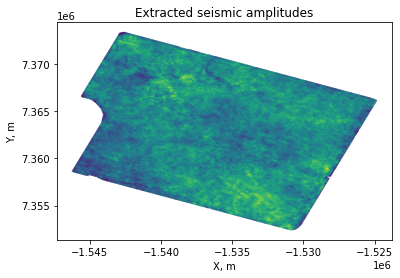

In [27]:
plt.scatter(whole_df['x'], whole_df['y'], c=whole_df['amplitudes'], s=0.01)
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.title('Extracted seismic amplitudes')
plt.show()

In [28]:
#разделение набора с толщинами на тренировчные и контрольные данные
df_for_train = whole_df[(whole_df.wellname != 'none') & (whole_df.wellname.str.contains('train'))]
df_for_train.head()

,iline_number,xline_number,x,y,z,wellname,Heff,well_x_original,well_y_original,amplitudes
1450,94,407,-1.539064e+06,7.355771e+06,1477.77930,well_train_1,7.7,-1.539054e+06,7.355771e+06,8528.925781
3838,98,320,-1.541035e+06,7.356674e+06,1497.13599,well_train_8,4.1,-1.541044e+06,7.356694e+06,12036.484375
18706,120,331,-1.540576e+06,7.357079e+06,1491.32532,well_train_7,0.3,-1.540578e+06,7.357085e+06,15289.039062
19349,121,294,-1.541420e+06,7.357447e+06,1496.32898,well_train_9,3.1,-1.541421e+06,7.357450e+06,14390.113281
50092,166,307,-1.540701e+06,7.358364e+06,1495.60217,well_train_37,2.7,-1.540718e+06,7.358379e+06,16569.394531


In [29]:
index = df_for_train.index
index

Int64Index([  1450,   3838,  18706,  19349,  50092,  72579,  78766,  94066,
             97214, 168801, 171711, 187663, 202699, 283859, 287704, 290083,
            292539, 299688, 300683, 302167, 309544, 309633, 310861, 312890,
            313485, 314969, 315532, 321466, 321735, 337287, 339637, 372908,
            375219, 390835, 392443, 396360, 400355, 402721, 432325, 433859],
           dtype='int64')

In [30]:
#idx=np.random.permutation(index)
idx = np.array([310861, 283859, 400355, 309633,  50092, 202699, 315532, 339637,
       300683, 321466, 432325, 396360,   3838, 171711, 309544, 299688,
       168801,   1450,  19349, 433859, 375219, 292539, 337287, 392443,
       290083,  94066, 372908, 314969, 312890,  97214, 402721, 287704,
       390835, 187663, 302167,  18706,  72579, 321735,  78766, 313485],
      dtype=int)

In [31]:
# [0:28]  for train
# [28:34] for val
# [34:]   for test

amplitudes_0ms_train = df_for_train.amplitudes[idx[:28]].values.astype('float32')
amplitudes_0ms_test = df_for_train.amplitudes[idx[34:]].values.astype('float32')

heff_train = df_for_train.Heff[idx[:28]].values.astype('float32')
heff_test = df_for_train.Heff[idx[34:]].values.astype('float32')

In [32]:
R_0ms_train = np.corrcoef(amplitudes_0ms_train, heff_train)[0][1]
print(R_0ms_train)

-0.35793711511908216


In [37]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [33]:
reg = LinearRegression(normalize = True).fit(amplitudes_0ms_train.reshape(-1,1), heff_train)
reg.score(amplitudes_0ms_train.reshape(-1,1), heff_train)

0.12811898123833554

In [34]:
reg.predict(amplitudes_0ms_train.reshape(-1,1))

array([4.1604304, 4.371632 , 3.907154 , 4.795368 , 4.5882354, 4.569548 ,
       4.159927 , 2.9129243, 2.9428048, 5.483087 , 3.6902719, 4.1177473,
       6.0867505, 5.4742775, 3.52278  , 4.460424 , 4.2344947, 7.2462993,
       5.308675 , 2.8150887, 3.743576 , 4.68909  , 3.1052346, 3.6624885,
       4.2515845, 2.9967752, 4.6906524, 3.312676 ], dtype=float32)

In [35]:
mean_squared_error(heff_test, reg.predict(amplitudes_0ms_test.reshape(-1,1)))

6.03664

In [40]:
reg.coef_, reg.intercept_

(array([-0.00033059], dtype=float32), 10.06584)

In [41]:
reg.predict(amplitudes_0ms_test.reshape(-1,1))

array([4.1917663, 5.0115027, 6.3824024, 3.6652894, 5.3419952, 2.9802756],
      dtype=float32)

In [42]:
model2=Ridge(alpha=0.01)
model2.fit(amplitudes_0ms_train.reshape(-1,1), heff_train)

Ridge(alpha=0.01)

In [43]:
model2.coef_

array([-0.00033059], dtype=float32)

In [44]:
mean_squared_error(heff_test, model2.predict(amplitudes_0ms_test.reshape(-1,1)))

6.0366416

In [45]:
model3=Lasso(alpha=0.001)
model3.fit(amplitudes_0ms_train.reshape(-1,1), heff_train)

Lasso(alpha=0.001)

In [46]:
mean_squared_error(heff_test, model3.predict(amplitudes_0ms_test.reshape(-1,1)))

6.03664

In [47]:
# metrics for training
R_0ms_train = np.corrcoef(amplitudes_0ms_train, heff_train)[0][1]
print(R_0ms_train)

regression_0ms = LinearRegression(normalize = True).fit(amplitudes_0ms_train.reshape(-1,1), heff_train)
predicted_regression_0ms = regression_0ms.predict(amplitudes_0ms_test.reshape(-1,1))

print(predicted_regression_0ms)
# metrics for test
R_0ms_test = np.corrcoef(predicted_regression_0ms, heff_test)[0][1]
MAE_test_0ms = mean_absolute_error(heff_test, predicted_regression_0ms)

print(R_0ms_test)
print(MAE_test_0ms)
#cross_val_score(LinearRegression(), amplitudes_0ms_train.reshape(-1,1), heff_train, cv=10, scoring='r2')#.mean()

-0.35793711511908216
[4.1917663 5.0115027 6.3824024 3.6652894 5.3419952 2.9802756]
-0.12847781149418072
1.9904419


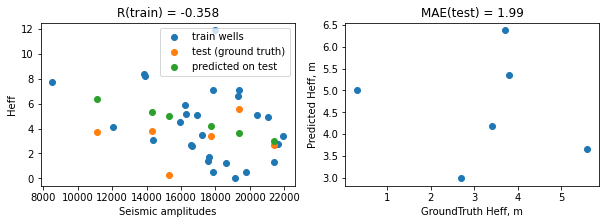

In [48]:
fig, (amp_heff, heff_heff) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
amp_heff.scatter(amplitudes_0ms_train, heff_train, label='train wells')
amp_heff.scatter(amplitudes_0ms_test, heff_test, label='test (ground truth)')
amp_heff.scatter(amplitudes_0ms_test, predicted_regression_0ms, label='predicted on test')
amp_heff.set_title(f'R(train) = {np.round(R_0ms_train,3)}')
amp_heff.set_xlabel('Seismic amplitudes')
amp_heff.set_ylabel('Heff')
amp_heff.legend()

heff_heff.scatter(heff_test, predicted_regression_0ms, label='predicted on test')

heff_heff.set_title(f'MAE(test) = {np.round(float(MAE_test_0ms),3)}')

heff_heff.set_xlabel('GroundTruth Heff, m')
heff_heff.set_ylabel('Predicted Heff, m')
plt.show()

In [49]:
new_attributes = ['amplitudes_2ms', 'amplitudes_4ms', 'amplitudes_6ms', 'amplitudes_8ms', 'amplitudes_10ms', 
                  'amplitudes_12ms', 'amplitudes_14ms', 'amplitudes_16ms', 'amplitudes_18ms']

for k in new_attributes:
    whole_df[k] = np.nan

In [50]:
for q in tqdm(range(2,20,2)):

    for k in whole_df.index:
        line = whole_df.loc[k]
        actual_time = line['z'] - DEPTH_IN_TIME*dt
        
        # int(q / 2) because we need only 1 discrete (1 discrete = 2ms)
        actual_time_on_seismic = int((actual_time - (actual_time % 2)) / 2) + int(q / 2) 

        whole_df.at[k, ('amplitudes_' + str(q) + 'ms')] = seis_npy[
            line['iline_number'] - ILINE_START, 
            line['xline_number'] - XLINE_START,
            actual_time_on_seismic]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:10<00:00, 41.21s/it]


In [51]:
df_for_train = whole_df[(whole_df.wellname != 'none') & (whole_df.wellname.str.contains('train'))]

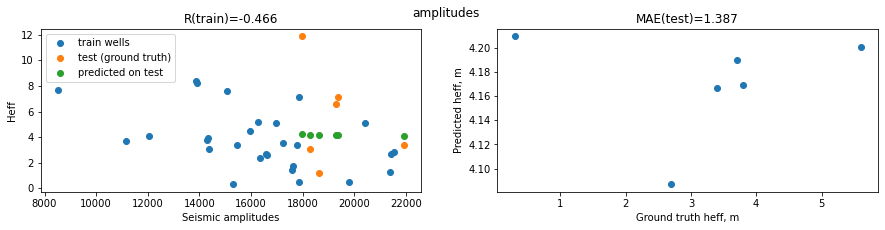

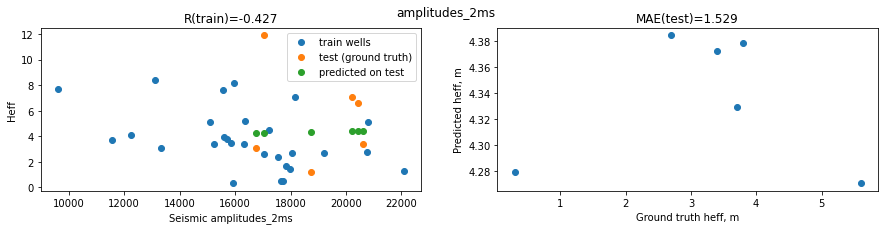

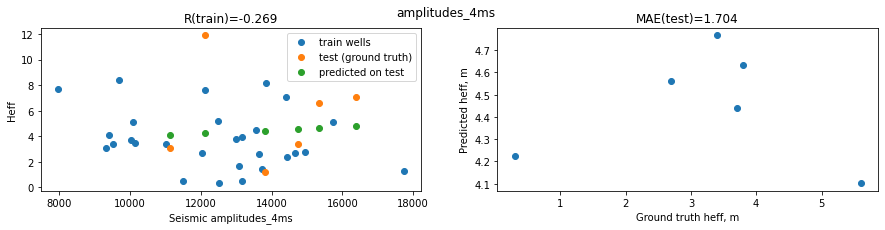

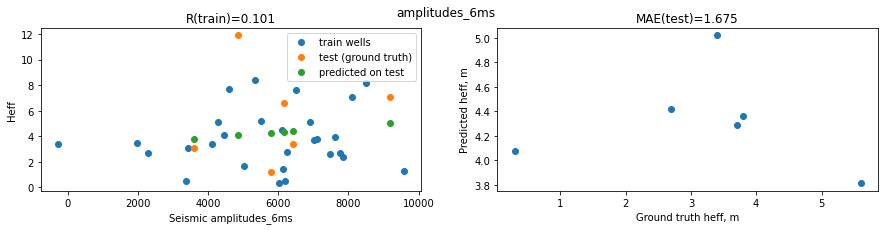

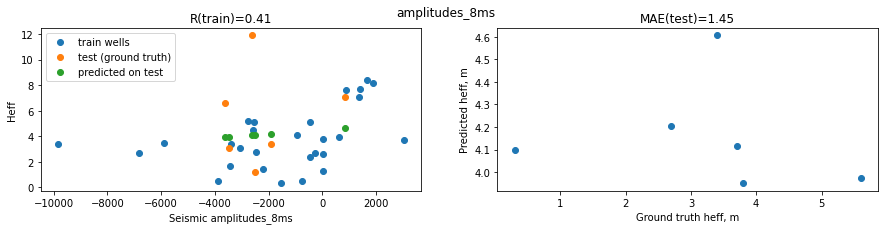

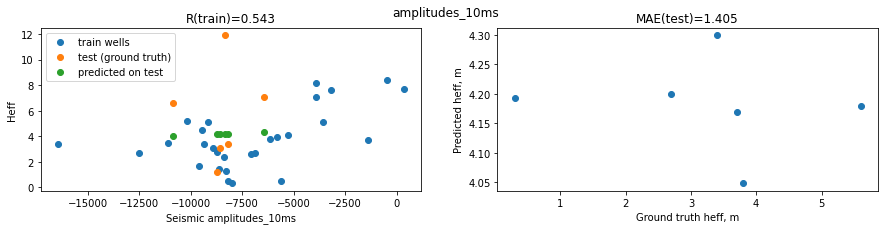

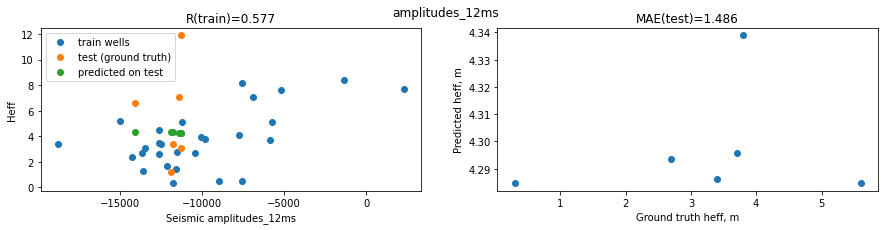

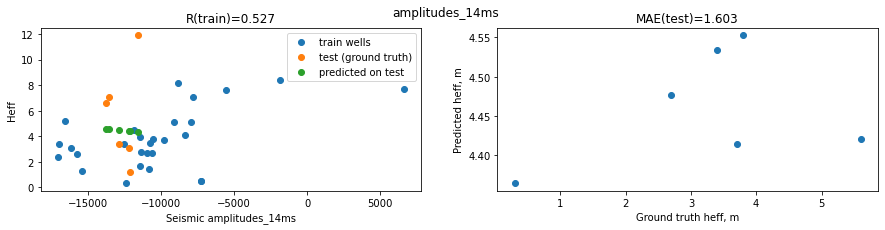

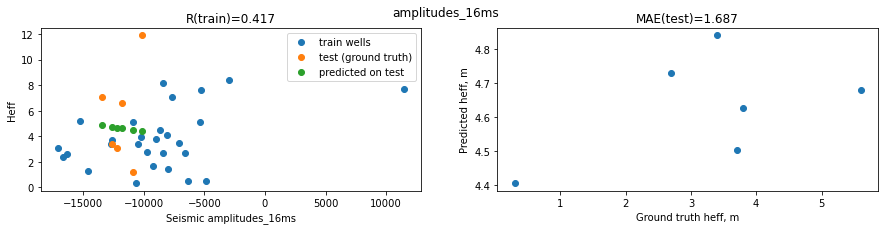

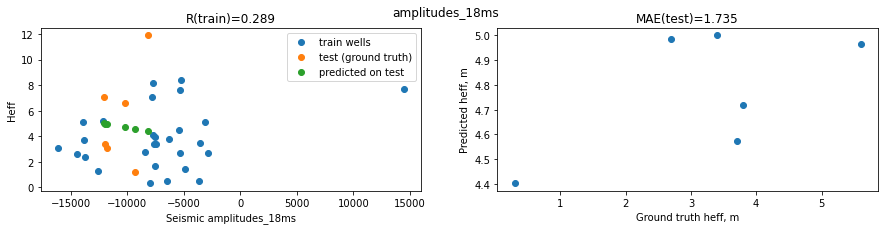

In [52]:
columns = df_for_train.columns[df_for_train.columns.str.contains('amplitudes')].values

for i, k in enumerate(columns):
    fig, (amp_heff, heff_heff) = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    
    amplitudes_train = df_for_train[k].values[0:28]
    amplitudes_test = df_for_train[k].values[34:]
    h_eff_train = df_for_train['Heff'].values[0:28]
    h_eff_test = df_for_train['Heff'].values[34:]
    
    R_train = np.round(np.corrcoef(amplitudes_train, h_eff_train)[0][1], 3)
    
    regression_on_train = LinearRegression().fit(amplitudes_train.reshape(-1,1), heff_train)
    predicted_regression_on_train = regression_on_train.predict(amplitudes_test.reshape(-1,1))

    # metrics for test
    R_test = np.round(np.corrcoef(predicted_regression_on_train, heff_test)[0][1], 3)
    MAE_test = np.round(mean_absolute_error(heff_test, predicted_regression_on_train), 3)
    
    amp_heff.scatter(amplitudes_train, h_eff_train, label='train wells')
    amp_heff.scatter(amplitudes_test, h_eff_test, label='test (ground truth)')
    amp_heff.scatter(amplitudes_test, predicted_regression_on_train, label='predicted on test')
    amp_heff.set_xlabel(f'Seismic {k}')
    amp_heff.set_ylabel('Heff')
    amp_heff.set_title(f'R(train)={R_train}')
    amp_heff.legend()
    
    heff_heff.scatter(heff_test, predicted_regression_on_train)
    heff_heff.set_xlabel('Ground truth heff, m')
    heff_heff.set_ylabel('Predicted heff, m')
    heff_heff.set_title(f'MAE(test)={MAE_test}')
    
    fig.suptitle(k)
    
plt.show()

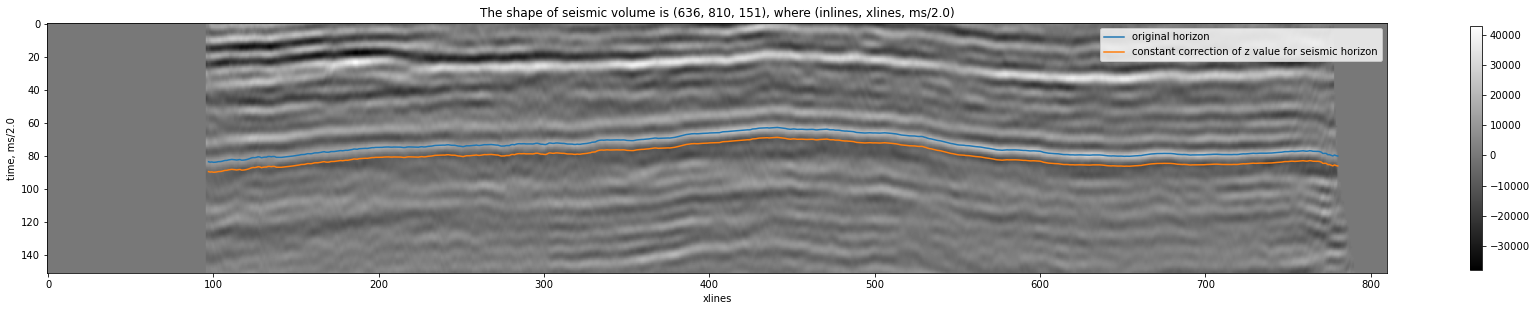

In [53]:
plt.figure(figsize=(30,30))
vertical_view = plt.imshow(seis_npy[iline, :, :].T, cmap='gray')
plt.plot(
    whole_df[(whole_df.iline_number - ILINE_START) == iline].xline_number, 
    (whole_df[(whole_df.iline_number - ILINE_START) == iline].z - DEPTH_IN_TIME*dt) / dt,
    label='original horizon'
)
plt.plot(
    whole_df[(whole_df.iline_number - ILINE_START) == iline].xline_number, 
    (whole_df[(whole_df.iline_number - ILINE_START) == iline].z - DEPTH_IN_TIME*dt) / dt + 12/2,
    label='constant correction of z value for seismic horizon'
)
plt.title(f'The shape of seismic volume is {seis_npy.shape}, where (inlines, xlines, ms/{dt})')
plt.ylabel(f'time, ms/{dt}')
plt.xlabel('xlines')
plt.colorbar(vertical_view, shrink=0.15)
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<b> ML</b>
</div>

In [54]:
selected_attributes = ['amplitudes', 'amplitudes_12ms'] # columns

In [55]:
x = whole_df[(whole_df.wellname != 'none') & (whole_df.wellname.str.contains('train'))]

In [56]:
y = x['Heff'].values.astype('float32')
x = x[selected_attributes].values.astype('float32')

In [57]:
x = (x - x.flatten().min()) / (x.flatten().max() - x.flatten().min())

In [58]:
x_train = x[0:28]
y_train = y[0:28]

x_val = x[28:34]
y_val = y[28:34]

x_test = x[34:]
y_test = y[34:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(28, 2) (28,)
(6, 2) (6,)
(6, 2) (6,)


In [59]:
model = Sequential([
    Dense(4, activation='relu', input_shape=(2,)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='relu')
])

In [60]:
!rm -rf best_models

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [61]:
model.compile(optimizer='adam', loss='mae', metrics=['mse'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                    batch_size=8, epochs=100, verbose=1, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint(
                            'best_models/', monitor='val_loss', verbose=1, 
                            save_best_only=True, save_weights_only=False, 
                            mode='min', save_freq='epoch')
                    ]
                   )

Epoch 1/100
1/4 [======>.......................] - ETA: 1s - loss: 4.3138 - mse: 23.5590
Epoch 1: val_loss improved from inf to 4.11645, saving model to best_models\
INFO:tensorflow:Assets written to: best_models\assets
4/4 [==============================] - 1s 247ms/step - loss: 3.7659 - mse: 19.3155 - val_loss: 4.1165 - val_mse: 21.2331
Epoch 2/100
1/4 [======>.......................] - ETA: 0s - loss: 3.8390 - mse: 17.9761
Epoch 2: val_loss improved from 4.11645 to 4.00669, saving model to best_models\
INFO:tensorflow:Assets written to: best_models\assets
4/4 [==============================] - 1s 183ms/step - loss: 3.6379 - mse: 18.4059 - val_loss: 4.0067 - val_mse: 19.8698
Epoch 3/100
1/4 [======>.......................] - ETA: 0s - loss: 4.9468 - mse: 32.0491
Epoch 3: val_loss improved from 4.00669 to 3.85604, saving model to best_models\
INFO:tensorflow:Assets written to: best_models\assets
4/4 [==============================] - 1s 221ms/step - loss: 3.4920 - mse: 17.0235 - val_l

1/4 [======>.......................] - ETA: 0s - loss: 1.5633 - mse: 5.2136
Epoch 30: val_loss did not improve from 1.79835
4/4 [==============================] - 0s 5ms/step - loss: 1.8109 - mse: 5.7893 - val_loss: 2.1744 - val_mse: 5.6268
Epoch 31/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1849 - mse: 5.3198
Epoch 31: val_loss did not improve from 1.79835
4/4 [==============================] - 0s 5ms/step - loss: 1.6883 - mse: 5.7626 - val_loss: 2.2059 - val_mse: 5.8167
Epoch 32/100
1/4 [======>.......................] - ETA: 0s - loss: 1.8393 - mse: 5.8092
Epoch 32: val_loss did not improve from 1.79835
4/4 [==============================] - 0s 5ms/step - loss: 1.7783 - mse: 5.7138 - val_loss: 2.1936 - val_mse: 5.7305
Epoch 33/100
1/4 [======>.......................] - ETA: 0s - loss: 1.9163 - mse: 4.7365
Epoch 33: val_loss did not improve from 1.79835
4/4 [==============================] - 0s 5ms/step - loss: 2.0007 - mse: 6.0146 - val_loss: 2.1740 - val_mse: 5.61

Epoch 61/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6886 - mse: 3.7526
Epoch 61: val_loss did not improve from 1.43742
4/4 [==============================] - 0s 5ms/step - loss: 1.5089 - mse: 3.6703 - val_loss: 1.8072 - val_mse: 4.7724
Epoch 62/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4052 - mse: 2.7557
Epoch 62: val_loss did not improve from 1.43742
4/4 [==============================] - 0s 5ms/step - loss: 1.5315 - mse: 3.3731 - val_loss: 1.7139 - val_mse: 4.6410
Epoch 63/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3553 - mse: 3.5142
Epoch 63: val_loss did not improve from 1.43742
4/4 [==============================] - 0s 5ms/step - loss: 1.5438 - mse: 3.8449 - val_loss: 1.5953 - val_mse: 4.6630
Epoch 64/100
1/4 [======>.......................] - ETA: 0s - loss: 1.8197 - mse: 4.3263
Epoch 64: val_loss did not improve from 1.43742
4/4 [==============================] - 0s 5ms/step - loss: 1.7390 - mse: 4.2742 - val_loss: 1.6433 - 

1/4 [======>.......................] - ETA: 0s - loss: 1.6970 - mse: 3.4293
Epoch 93: val_loss did not improve from 1.43742
4/4 [==============================] - 0s 5ms/step - loss: 1.7521 - mse: 4.9129 - val_loss: 1.7972 - val_mse: 4.6445
Epoch 94/100
1/4 [======>.......................] - ETA: 0s - loss: 1.7124 - mse: 5.4643
Epoch 94: val_loss did not improve from 1.43742
4/4 [==============================] - 0s 5ms/step - loss: 1.5808 - mse: 4.6754 - val_loss: 1.7076 - val_mse: 4.5461
Epoch 95/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3205 - mse: 3.1665
Epoch 95: val_loss did not improve from 1.43742
4/4 [==============================] - 0s 5ms/step - loss: 1.6084 - mse: 4.3042 - val_loss: 1.5989 - val_mse: 4.5885
Epoch 96/100
1/4 [======>.......................] - ETA: 0s - loss: 1.8953 - mse: 4.3005
Epoch 96: val_loss did not improve from 1.43742
4/4 [==============================] - 0s 5ms/step - loss: 1.5079 - mse: 3.4945 - val_loss: 1.6910 - val_mse: 4.54

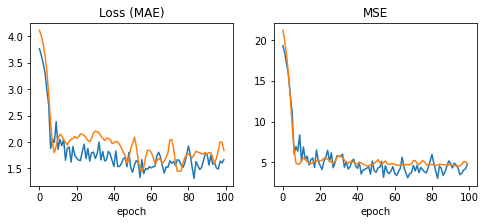

In [62]:
fig, (loss, mse) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

loss.set_title('Loss (MAE)')
loss.plot(history.history['loss'])
loss.plot(history.history['val_loss'])
loss.set_xlabel('epoch')


mse.set_title('MSE')
mse.plot(history.history['mse'])
mse.plot(history.history['val_mse'])
mse.set_xlabel('epoch')


plt.show()

In [63]:
model = load_model('best_models/')

In [64]:
mae_eval, mse_eval = model.evaluate(x_test, y_test, verbose=0)
print(f'MAE on test: {np.round(mae_eval,3)}, MSE on test: {np.round(mse_eval,3)}')

MAE on test: 2.987, MSE on test: 16.208


In [65]:
predicted = model.predict(x_test)

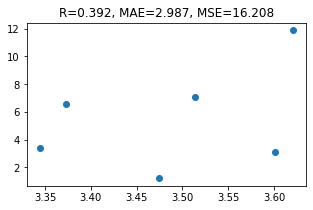

In [66]:
plt.figure(figsize=(5,3))
plt.scatter(predicted, y_test)
plt.title(f'R={np.round(np.corrcoef(predicted.flatten(), y_test)[0][1], 3)}, ' + 
          f'MAE={np.round(float(mean_absolute_error(y_test, predicted)), 3)}, ' +
          f'MSE={np.round(float(mean_squared_error(y_test, predicted)), 3)}'
         )
plt.show()

результаты предсказаний

In [67]:
x_test = whole_df[(whole_df.wellname != 'none') & (whole_df.wellname.str.contains('well_test'))]

In [68]:
x_test = x_test[selected_attributes].values.astype('float32')

In [69]:
x_test = (x_test - x_test.flatten().min()) / (x_test.flatten().max() - x_test.flatten().min())

In [70]:
predicted_test = model.predict(x_test)

In [71]:
predicted_test

array([[5.9044905],
       [3.4048505],
       [3.378634 ],
       [3.432913 ]], dtype=float32)

In [72]:
!rm heff_test_predicted.txt

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [73]:
x_test = whole_df[(whole_df.wellname != 'none') & (whole_df.wellname.str.contains('well_test'))]
x_test = x_test.filter(['well_x_original', 'well_y_original', 'Heff'])
x_test['Heff'] = predicted_test.reshape(4)
np.savetxt('heff_test_predicted.txt', x_test.values, delimiter=' ', encoding='utf-8')

In [74]:
x_blind_test = whole_df[(whole_df.wellname != 'none') & (whole_df.wellname.str.contains('blind'))]

In [75]:
x_blind_test = x_blind_test[selected_attributes].values.astype('float32')

In [76]:
x_blind_test = (x_blind_test - x_blind_test.flatten().min()) / (x_blind_test.flatten().max() - x_blind_test.flatten().min())

In [77]:
predicted_blind_test = model.predict(x_blind_test)

In [78]:
predicted_blind_test

array([[6.4635487],
       [3.3941882],
       [3.4069026],
       [3.4259763]], dtype=float32)

In [79]:
!rm heff_blind_test_predicted.txt

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [80]:
x_blind_test = whole_df[(whole_df.wellname != 'none') & (whole_df.wellname.str.contains('blind'))]
x_blind_test = x_blind_test.filter(['well_x_original', 'well_y_original', 'Heff'])
x_blind_test['Heff'] = predicted_blind_test.reshape(4)
np.savetxt('heff_blind_test_predicted.txt', x_blind_test.values, delimiter=' ', encoding='utf-8')